In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, dateutil

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# DEAD ANIMALS

In [2]:
train = pd.read_csv('train.csv')
display(train.dtypes)
display(train.head())
display(train.describe())

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A694279,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [3]:
import re
sterilized_pat = re.compile('.*(neutered|spayed).*', flags=re.IGNORECASE)

def purify_age(df):
    days_in_unit = {
    'day': 1,
    'days': 1,
    'week': 7,
    'weeks': 7,
    'month': 30,
    'months': 30,
    'years': 365,
    'year': 365
    }
    
    def strage_to_days(age):
        if not isinstance(age, str): return float('nan')
        age = age.split(' ')
        return int(age[0]) * days_in_unit[age[1]]
    df['AgeuponOutcome'] = df['AgeuponOutcome'].map(strage_to_days)

def purify_sex(df):
    df['Sterilized'] = df.SexuponOutcome.str.match(sterilized_pat)
    df.loc[df['Sterilized'].isnull(), 'Sterilized'] = 2
    df['Sterilized'] = df['Sterilized'].astype('int')
    def shorten_sex(sex):
        if isinstance(sex, str):
            if 'Male' in sex:
                return 0
            elif 'Female' in sex:
                return 1
        return 2 # the Unknown
    df['SexuponOutcome'] = df['SexuponOutcome'].map(shorten_sex).astype('int')

import datetime

def datetime_purify(df):
    def transform_date(date):
        date = dateutil.parser.parse(date)
        date = datetime.datetime(year=date.year, month=date.month, day=date.day, hour=date.hour)
        return date
    df.DateTime = df.DateTime.apply(transform_date)
    
def purify_1(df):
    df = df.drop(['ID', 'AnimalID'], axis=1, errors='ignore')
    df['Name'] = pd.notnull(df['Name'])
    df['Mix'] = df.Breed.str.match(re.compile('.*(Mix|/)')).astype('int')
    df['Breed'] = df.Breed.str.rstrip(' Mix')
    df['Multicolor'] = df.Color.str.contains('/')
    df.loc[df['Color'].str.match(
        re.compile('.*(multi|poly|parti|point|calico).*',
                   flags=re.IGNORECASE)), 'Multicolor'] = 1
    purify_age(df)
    purify_sex(df)
    datetime_purify(df)
    return df

applied_transforms = [purify_1]

In [4]:
X = purify_1(train)
X.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
0,True,2014-02-12 18:00:00,Return_to_owner,NaN,Dog,0,365.0,Shetland Sheepdog,Brown/White,1,True,1
1,True,2013-10-13 12:00:00,Euthanasia,Suffering,Cat,1,365.0,Domestic Shorthair,Cream Tabby,1,False,1
2,True,2015-01-31 12:00:00,Adoption,Foster,Dog,0,730.0,Pit Bull,Blue/White,1,True,1
3,False,2014-07-11 19:00:00,Transfer,Partner,Cat,0,21.0,Domestic Shorthair,Blue Cream,1,False,0
4,False,2013-11-15 12:00:00,Transfer,Partner,Dog,0,730.0,Lhasa Apso/Miniature Poodle,Tan,1,False,1


In [5]:
df = X[['Breed', 'AgeuponOutcome']].groupby('Breed').describe()
df[df['AgeuponOutcome', 'count'] > 100]

AgeuponOutcome                                  \
                                        count         mean          std   min   
Breed                                                                           
American Bulldog                        115.0   866.478261   718.065436   5.0   
American Staffordshire Terrier          104.0   941.625000   854.172673   2.0   
Australian Cattle Dog                   392.0   890.272959  1127.644638   7.0   
Australian Kelpie                       101.0   478.960396   632.389878  21.0   
Australian Shepherd                     177.0  1095.553672  1282.903777  28.0   
Beagle                                  146.0  1582.910959  1394.064110  30.0   
Border Collie                           246.0   993.321138  1270.271987  14.0   
Boxer                                   275.0  1048.909091  1106.237248  30.0   
Cairn Terrier                           112.0   685.982143   714.100846  30.0   
Catahoula                               163.0   790.214724   991.254092  30.0   
Chihuahua Longhair                      151.0  1019.960265  1050.491142   6.0   
Chihuahua Shorthair                    1851.0  1078.337115  1178.801408   4.0   
Dachshund                               364.0  1181.478022  1231.437592   2.0   
Domestic Longhair                       542.0  1021.911439  1417.130079   0.0   
Domestic Medium Hair                    881.0   530.437003   978.291017   3.0   
Domestic Shorthair                     8937.0   428.381112   844.626310   0.0   
German Shepherd                         652.0   892.253067  1078.210628   2.0   
Jack Russell Terrier                    162.0  1172.580247  1349.304595  28.0   
Labrador Retriever                     1432.0   961.934358  1195.602491   1.0   
Miniature Poodle                        254.0  1358.484252  1295.898579  30.0   
Miniature Schnauzer                     158.0  1411.455696  1316.632491  60.0   
Pit Bull                               1972.0   865.593306   821.283950   1.0   
Rat Terrier                             170.0  1525.105882  1548.908770   6.0   
Rottweiler                              152.0  1194.065789  1071.716088   0.0   
Shih Tzu                                153.0  1534.882353  1297.703285   7.0   
Siamese                                 413.0   695.450363  1172.716271   2.0   
Siberian Husky                          168.0  1081.130952  1078.709129  60.0   
Staffordshire                           102.0   874.460784   645.364624  60.0   
Yorkshire Terrier                       167.0  1438.958084  1392.182063   3.0   

                                                                
                                  25%     50%      75%     max  
Breed                                                           
American Bulldog                365.0   730.0  1095.00  2920.0  
American Staffordshire Terrier  365.0   730.0  1095.00  4015.0  
Australian Cattle Dog           150.0   365.0  1095.00  5840.0  
Australian Kelpie               120.0   330.0   730.00  4015.0  
Australian Shepherd             180.0   730.0  1460.00  6205.0  
Beagle                          365.0  1095.0  2555.00  5475.0  
Border Collie                   150.0   365.0  1095.00  5840.0  
Boxer                           300.0   730.0  1460.00  5110.0  
Cairn Terrier                   232.5   365.0   730.00  3650.0  
Catahoula                       180.0   365.0  1095.00  5110.0  
Chihuahua Longhair              300.0   730.0  1460.00  5475.0  
Chihuahua Shorthair             365.0   730.0  1460.00  6570.0  
Dachshund                       300.0   730.0  1825.00  5840.0  
Domestic Longhair                60.0   365.0  1460.00  6570.0  
Domestic Medium Hair             60.0   120.0   365.00  7300.0  
Domestic Shorthair               30.0    90.0   365.00  7300.0  
German Shepherd                 180.0   365.0  1095.00  5840.0  
Jack Russell Terrier            157.5   730.0  1825.00  5475.0  
Labrador Retriever              120.0   365.0  1460.00  6205.0  
Miniatur

In [6]:
X.isnull().sum()

Name                  0
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        0
AgeuponOutcome       18
Breed                 0
Color                 0
Mix                   0
Multicolor            0
Sterilized            0
dtype: int64

In [7]:
X[['AnimalType', 'Mix', 'AgeuponOutcome']].groupby(['AnimalType', 'Mix']).describe()

AgeuponOutcome                                                \
                        count         mean          std  min    25%     50%   
AnimalType Mix                                                                
Cat        0            253.0   619.209486  1145.915947  2.0   60.0   120.0   
           1          10864.0   493.310659   936.473840  0.0   35.0    90.0   
Dog        0           1138.0  1511.528120  1321.028133  2.0  365.0  1095.0   
           1          14456.0   966.790329  1099.315319  0.0  240.0   730.0   

                                
                   75%     max  
AnimalType Mix                  
Cat        0     730.0  6935.0  
           1     365.0  7300.0  
Dog        0    2190.0  6935.0  
           1    1095.0  6935.0

### Missing data

In [8]:
display(
    X.loc[X['Sterilized'] == 2],
    X.loc[X['Mix'] == 2],
    X.loc[X['SexuponOutcome'] == 2].head(),
    X.loc[X['AgeuponOutcome'].isnull()],
    X.loc[X['AgeuponOutcome'].isnull()].describe())

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
3174,True,2013-11-27 16:00:00,Return_to_owner,NaN,Dog,2,2555.0,Dachshund,Brown Merle,0,False,2


,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized


,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
7,False,2015-04-30 17:00:00,Transfer,Partner,Cat,2,21.0,Domestic Shorthair,Brown Tabby,1,False,0
10,False,2013-12-05 15:00:00,Transfer,SCRP,Cat,2,730.0,Domestic Shorthair,Black,1,False,0
64,False,2014-07-17 17:00:00,Transfer,Partner,Cat,2,14.0,Domestic Shorthair,Black,1,False,0
68,False,2015-06-16 09:00:00,Transfer,SCRP,Cat,2,60.0,Domestic Shorthair,Brown Tabby/White,1,True,0
81,False,2015-09-22 12:00:00,Euthanasia,Suffering,Cat,2,14.0,Domestic Shorthair,Blue Tabby,1,False,0


,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
2480,False,2016-02-16 10:00:00,Transfer,SCRP,Cat,0,NaN,Domestic Shorthair,Blue Tabby/White,1,True,0
2912,False,2016-02-18 19:00:00,Transfer,SCRP,Cat,2,NaN,Domestic Shorthair,Gray Tabby,1,False,0
3766,False,2016-02-16 18:00:00,Transfer,SCRP,Cat,1,NaN,Domestic Shorthair,Brown Tabby,1,False,0
3875,False,2016-02-20 16:00:00,Euthanasia,Suffering,Dog,0,NaN,Toy Poodle,White,1,False,0
4498,False,2016-02-09 19:00:00,Transfer,SCRP,Cat,1,NaN,Domestic Shorthair,Brown Tabby,1,False,0
5137,False,2016-02-16 10:00:00,Transfer,SCRP,Cat,1,NaN,Domestic Shorthair,Black,1,False,1
5691,False,2016-02-16 10:00:00,Transfer,SCRP,Cat,2,NaN,Domestic Shorthair,Black Tabby/White,1,True,0
7005,False,2016-02-16 10:00:00,Transfer,SCRP,Cat,2,NaN,Domestic Shorthair,Black,1,False,0
8420,False,2016-02-16 10:00:00,Transfer,SCRP,Cat,0,NaN,Domestic Shorthair,Blue Tabby/White,1,True,0
17464,False,2016-02-16 18:00:00,Transfer,SCRP,Cat,1,NaN,Domestic Shorthair,Torbie,1,False,0


,SexuponOutcome,AgeuponOutcome,Mix,Sterilized
count,18.000000,0.0,18.0,18.000000
mean,0.888889,NaN,1.0,0.055556
std,0.758395,NaN,0.0,0.235702
min,0.000000,NaN,1.0,0.000000
25%,0.000000,NaN,1.0,0.000000
50%,1.000000,NaN,1.0,0.000000
75%,1.000000,NaN,1.0,0.000000
max,2.000000,NaN,1.0,1.000000


We can see that there are $18$ observations that miss `Age`
and all of these are `Mix`-ed animals.
We will fill these values with means or medians of their `Breed` $\times$ `Sex` $\times$ `Mix` group.

In [9]:
def impute_age(src, dst):
    for f, g in dst.loc[dst['AgeuponOutcome'].isnull()].groupby(['Breed', 'Mix', 'SexuponOutcome']):
        gtrain = src.loc[
                (src['Breed'] == f[0]) &
                (src['Mix'] == f[1]) &
                ( (src['SexuponOutcome'] == f[2]) ), # if f[2] else True ),
            'AgeuponOutcome']
        med, cnt = gtrain.median(), gtrain.count()
        if cnt < 30: med = gtrain.mean()
        dst.loc[dst['AgeuponOutcome'].isnull() &
             (dst['Breed'] == f[0]) &
             (dst['Mix'] == f[1]) &
             (dst['SexuponOutcome'] == f[2]),
                'AgeuponOutcome'] = med
        print('Imputed age %s from %s samples of %s %s %s' % (
              med, cnt,
              f[0],
              'Mix' if f[1] else '',
              'Male' if f[2] == 0 else ('Female' if f[2] == 1 else 'Agamous')))
    return dst

In [10]:
X = impute_age(X, X)

Imputed age 365.0 from 231 samples of Domestic Longhair Mix Male
Imputed age 90.0 from 3927 samples of Domestic Shorthair Mix Male
Imputed age 120.0 from 3967 samples of Domestic Shorthair Mix Female
Imputed age 21.0 from 900 samples of Domestic Shorthair Mix Agamous
Imputed age 1467.82608696 from 23 samples of Toy Poodle Mix Male


Looks like all of our groups had enough data.

In [11]:
applied_transforms.append(lambda X_te: impute_age(X, X_te))

### Splitting ages into groups

The "old" means different ages when speaking of different breeds.
So the age measured in days will likely confuse our model.
Now that we imputed missing data, we will split these into three separate variables
`days`, `months` and `years` only one of which will be non-zero in every specific case.

In [12]:
def split_ages(df):
    def split_age(age):
        if age < 30:
            units = 'days'
            qty = age
        elif age < 365:
            units = 'months'
            qty = age // 30
        else:
            units = 'years'
            qty = int(age/365.25)
        return pd.Series({
            'years': 0,
            'months': 0,
            'days': 0,
            units: qty
        })
    ages = df['AgeuponOutcome'].apply(split_age)
    df.drop('AgeuponOutcome', axis=1)
    return pd.concat((df, ages,), axis=1)
applied_transforms.append(split_ages)

In [13]:
X = split_ages(X)

### Periodicity

We have a `DateTime` variable which apparently is the date when the animal captured.
It is probably useless, but may the season matter?

In [14]:
def extract_month(X):
    X['Month'] = X['DateTime'].apply(lambda d: d.month)
    return X
applied_transforms.append(extract_month)
X = extract_month(X)

In [15]:
def extract_hour(X):
    X['Hour'] = X['DateTime'].apply(lambda d: d.hour)
    return X
applied_transforms.append(extract_hour)
X = extract_hour(X)

In [16]:
# from ggplot import *
import ggplot as gg

,Month,OutcomeType,Group
3,7,Transfer,Male Cat
6,3,Transfer,Male Cat
15,7,Adoption,Male Cat
16,5,Transfer,Male Cat
29,7,Return_to_owner,Male Cat


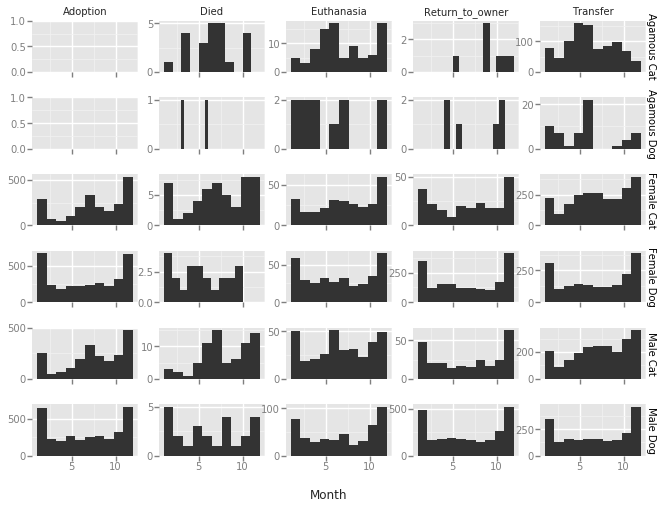

<ggplot: (-9223363298874022098)>

In [17]:
mon_avg_outcomes = pd.concat([g[['Month', 'OutcomeType']]\
 .assign(Group = lambda x: '%s %s' % (['Male', 'Female', 'Agamous'][f[1]], f[0]))
 for f, g in X.groupby(['AnimalType', 'SexuponOutcome'])],
          axis=0)
display(mon_avg_outcomes.head())
display(gg.ggplot(gg.aes(x='Month'), mon_avg_outcomes) +
    gg.geom_histogram() +
    gg.facet_grid('Group', 'OutcomeType', scales='free_y'))

Let us see if there really is any periodicity in outcomes:

In [18]:
mon_grouper = pd.Grouper(key='DateTime', freq='M')
mon_outcomes = pd.concat([g[['OutcomeType']]\
 .assign(DateTime=f[-1])\
 .assign(Group = lambda x: '%s %s' % (['Male', 'Female', 'Agamous'][f[1]], f[0]))
 for f, g in X.groupby(['AnimalType', 'SexuponOutcome', mon_grouper])],
          axis=0)

display(mon_outcomes.head(2))

,OutcomeType,DateTime,Group
187,Transfer,2013-10-31,Male Cat
219,Transfer,2013-10-31,Male Cat


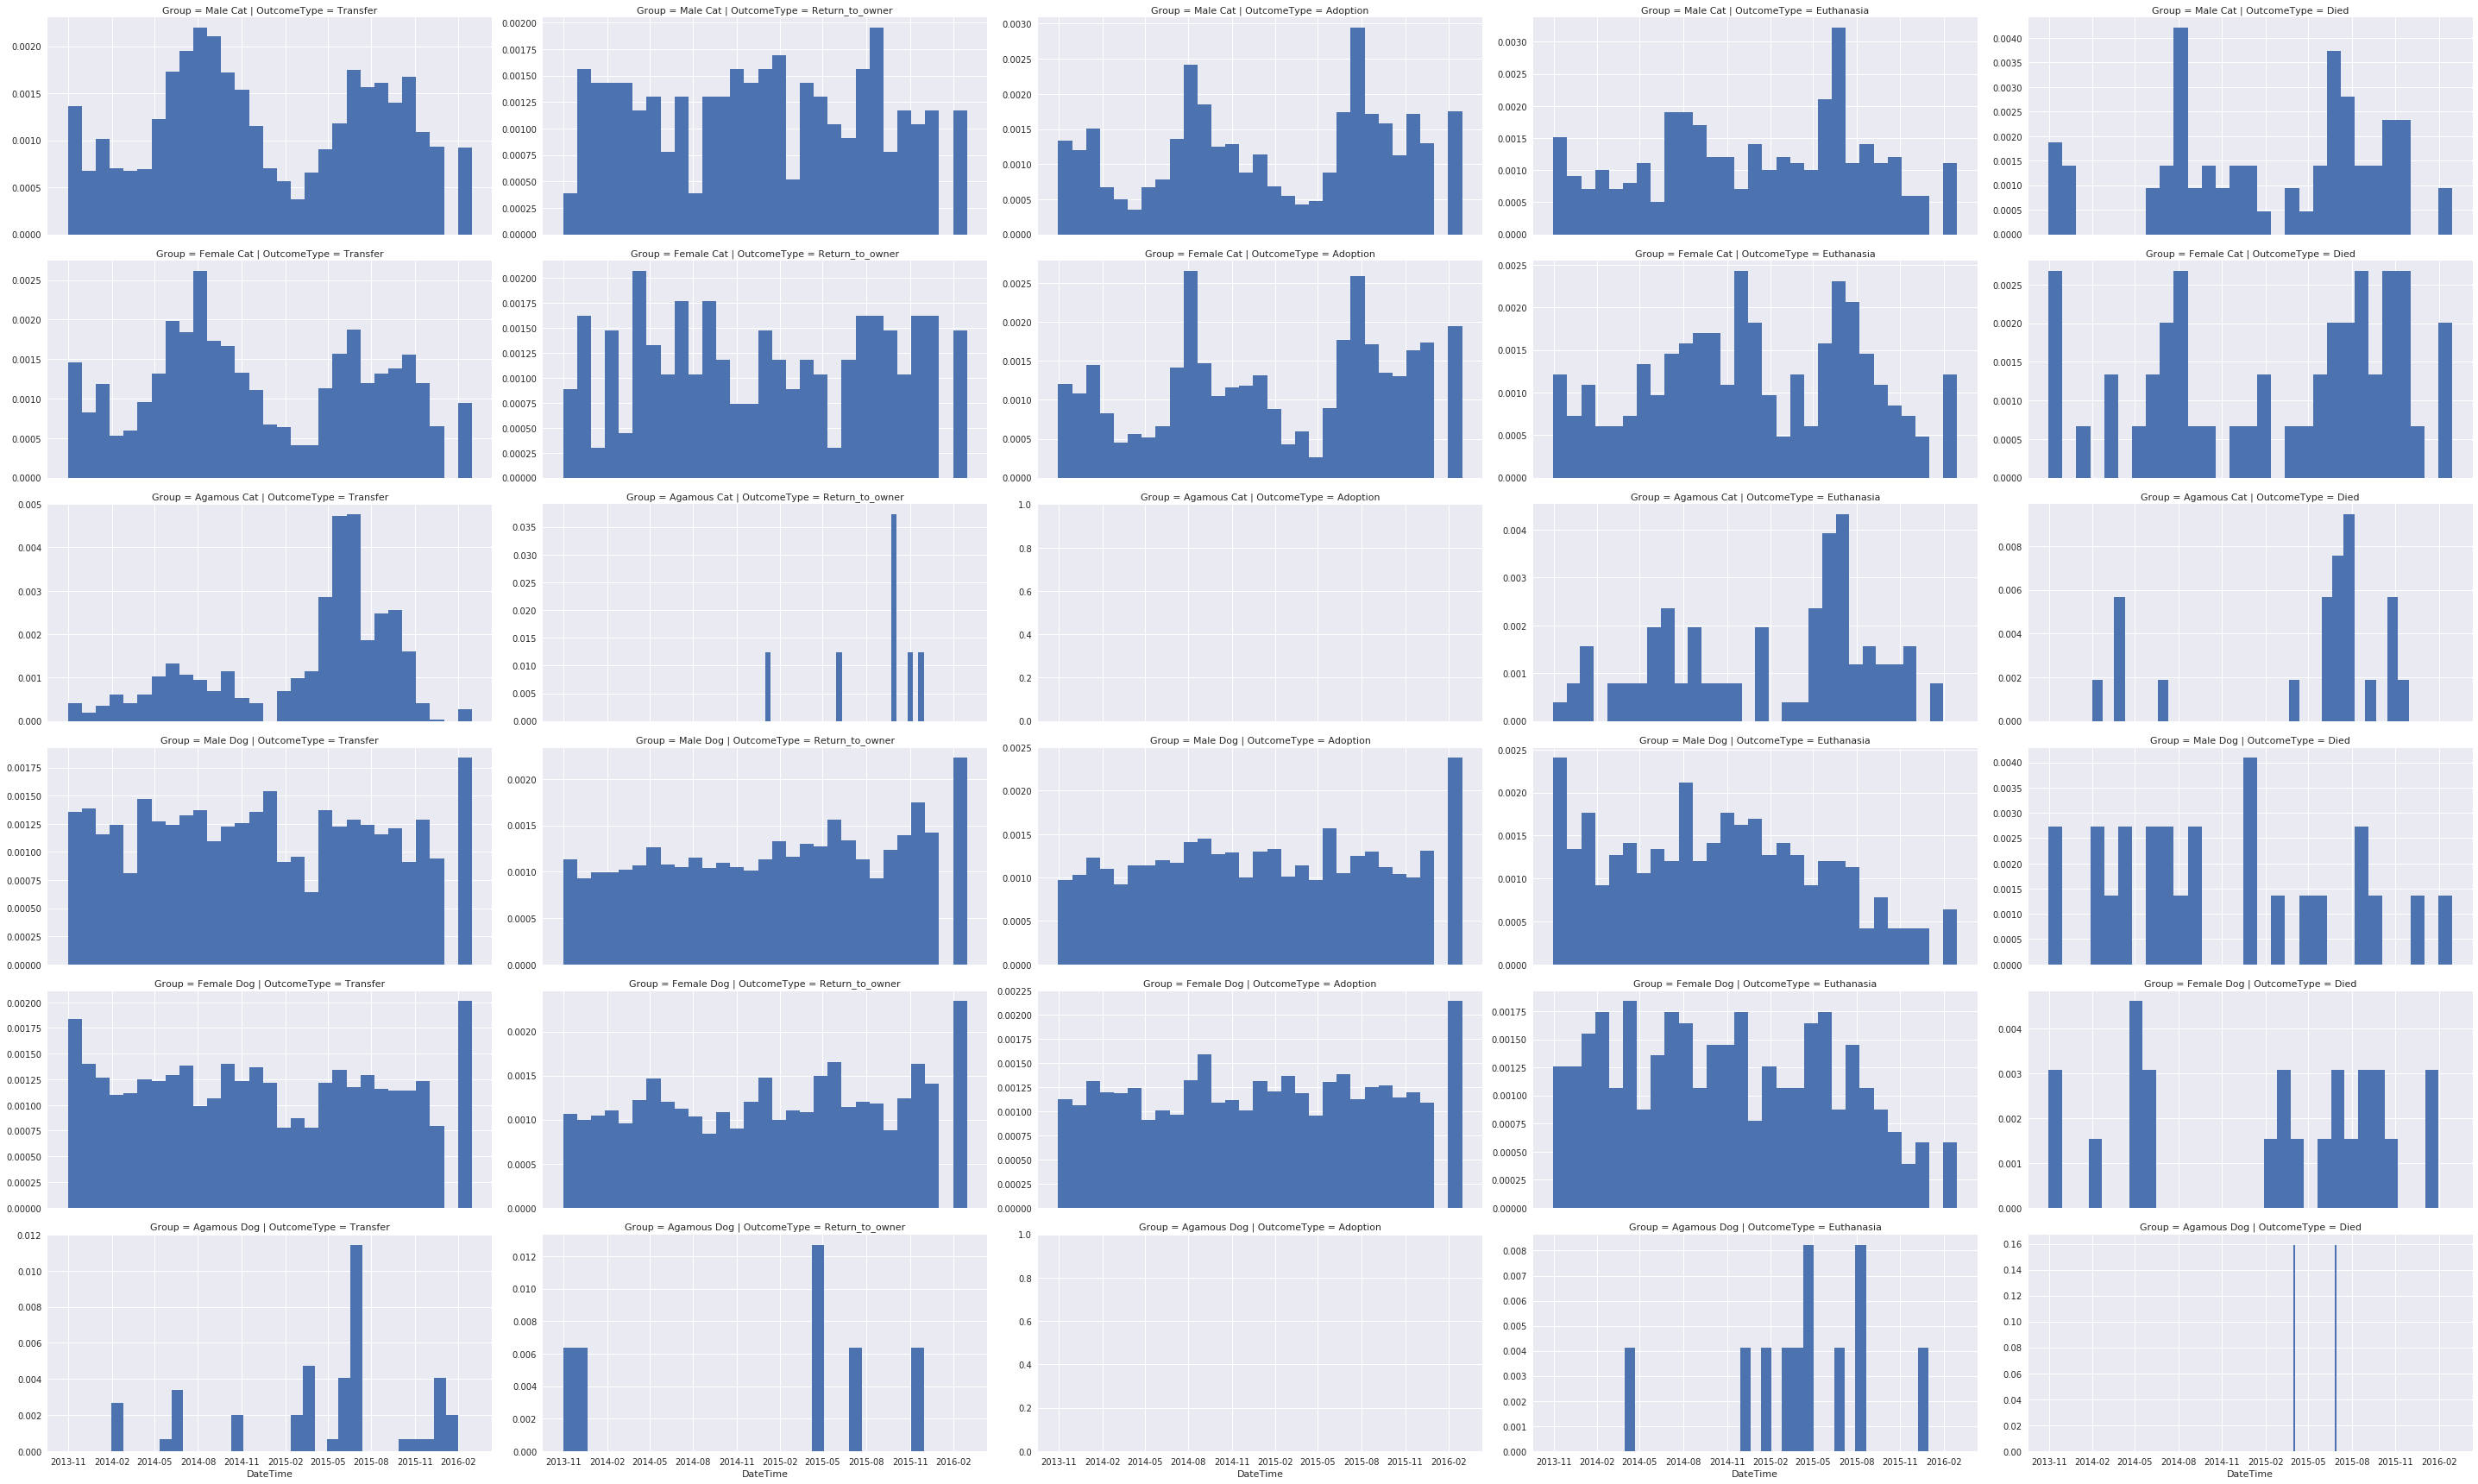

In [19]:
mon_outcomes_fg = sns.FacetGrid(mon_outcomes,
                                row='Group',
                                col='OutcomeType',
                                sharey=False,
                                size=4,
                                aspect=2)
mon_outcomes_fg.map(plt.hist, 'DateTime', normed=True, bins=mon_outcomes['DateTime'].unique().size)

Aside from `month`, the `DateTime` is clearly irrelevant, so let's drop it:

In [20]:
applied_transforms.append(lambda df: df.drop('DateTime', axis=1))
X = applied_transforms[-1](X)

In [21]:
def simplify_mixed_breeds(df):
    df['Breed'] = df['Breed'].str.replace(re.compile('([^/]+)/?.*'), '\\1')
    return df
applied_transforms.append(simplify_mixed_breeds)
X = simplify_mixed_breeds(X)

                                      25338
Domestic Shorthair                      143
Chihuahua Shorthair                      85
German Shepherd                          77
Labrador Retriever                       69
Pit Bull                                 66
Shih Tzu                                 53
Dachshund                                46
Domestic Medium Hair                     42
Rottweiler                               39
Boxer                                    30
Siberian Husky                           30
Pug                                      25
Australian Cattle Dog                    25
Siamese                                  24
Yorkshire Terrier                        24
Domestic Longhair                        23
Miniature Schnauzer                      22
Beagle                                   22
Miniature Poodle                         21
Cocker Spaniel                           20
Maltese                                  19
Border Collie                   

1391

140

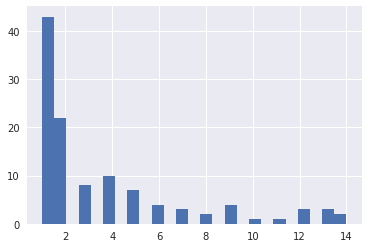

In [22]:
breed_cnts = (X.Breed * (1-X.Mix)).value_counts()
display(breed_cnts, (1-X.Mix).sum())
display(breed_cnts[breed_cnts < 15].hist(bins=25))
display(breed_cnts.size)

In [23]:
clrs_cnts = dict()

def canon_clr(clr):
    return clr.lower().strip().replace(' ', '')

for clrs in X['Color']:
    for clr in clrs.split('/'):
        clr = canon_clr(clr)
        if clr in clrs_cnts:
            clrs_cnts[clr] += 1
        else:
            clrs_cnts[clr] = 1
clrs_cnts = pd.Series(clrs_cnts).sort_values(ascending=False)

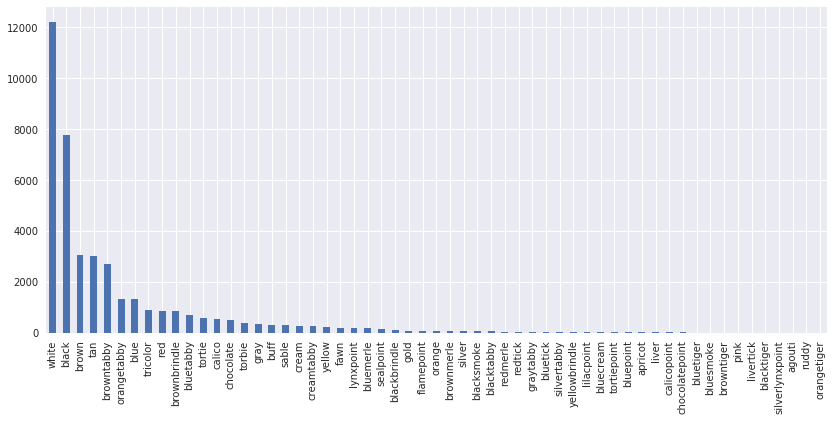

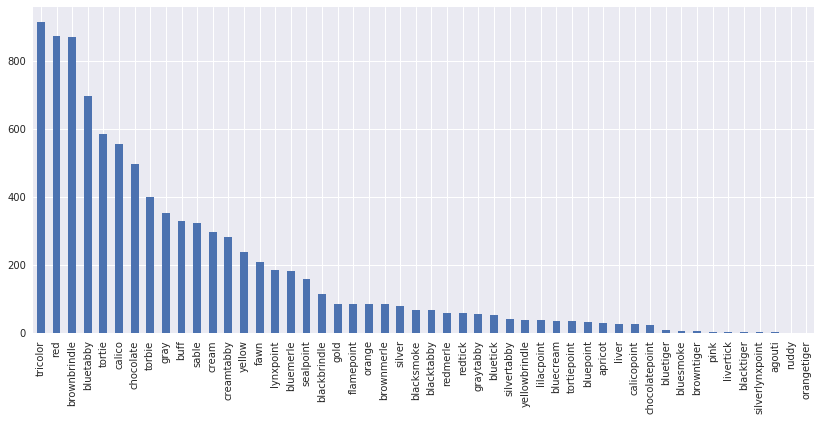

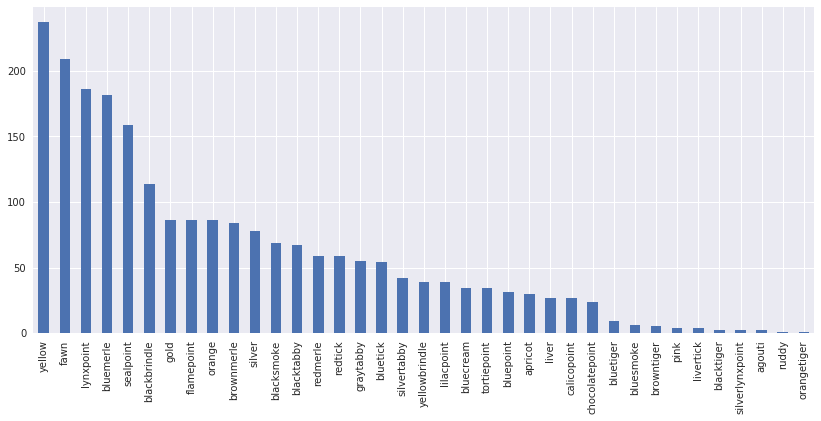

white              12198
black               7786
brown               3046
tan                 3031
browntabby          2696
orangetabby         1353
blue                1346
tricolor             912
red                  873
brownbrindle         868
bluetabby            696
tortie               584
calico               556
chocolate            495
torbie               398
gray                 352
buff                 328
sable                324
cream                296
creamtabby           282
yellow               237
fawn                 209
lynxpoint            186
bluemerle            182
sealpoint            159
blackbrindle         114
gold                  86
flamepoint            86
orange                86
brownmerle            84
silver                78
blacksmoke            69
blacktabby            67
redmerle              59
redtick               59
graytabby             55
bluetick              54
silvertabby           42
yellowbrindle         39
lilacpoint            39


In [24]:
clrs_cnts.plot(kind='bar', figsize=(14,6), )
plt.show()
clrs_cnts[clrs_cnts < 1000].plot(kind='bar', figsize=(14,6), )
plt.show()
clrs_cnts[clrs_cnts < 250].plot(kind='bar', figsize=(14,6), )
plt.show()
print(clrs_cnts)
print(clrs_cnts.size)

In [25]:
polycolors = {
    'tricolor',
    'point',
    'calico',
    'agouti',
    'merle',
    'tick',
    'tiger',
}

clrs_map = {
    'orangetiger': 'orange',
    'orangetabby': 'orange',
    'silverlynxpoint': 'gray',
    'blacktiger': 'black',
    'ruddy': 'orange',
    'red': 'orange',
    'brownbrindle': 'brown',
    'livertick': 'brown',
    'chocolate': 'brown',
    'fawn': 'brown',
    'tourtie': 'brown'
}


def strip_polycolors(clr):
    for pc in polycolors:
        clr = clr.replace(pc, '')
    return clr

all_colors = clrs_cnts.index.copy()
for clr in all_colors:
    good = strip_polycolors(clr)
    if good != clr:
        if good not in clrs_cnts.index:
            clrs_cnts[good] = 0
            print('added ', good)
        clrs_cnts[good] += clrs_cnts[clr]
        del clrs_cnts[clr]
        print('delted', clr)


for k, v in clrs_map.items():
    if k not in clrs_cnts:
        continue
    if v:
        clrs_cnts[v] += clrs_cnts[k]
    del clrs_cnts[k]
    
RARE_COLOR_TRESHOLD = 2000

for clr, cnt in clrs_cnts[clrs_cnts < RARE_COLOR_TRESHOLD].items():
    if clr not in clrs_map:
        clrs_map[clr] = None

for k, v in clrs_map.items():
    if k not in clrs_cnts:
        continue
    if v:
        clrs_cnts[v] += clrs_cnts[k]
    del clrs_cnts[k]


def extract_colors(df):
    def extr(colors):
        result = pd.Series({
            v: 0 for v in clrs_cnts.index
        })
        polycolor = False
        rarecolor = False
        for clr in colors.split('/'):
            clr = clr.lower().strip()
            monocolor = strip_polycolors(clr)
            if clr != monocolor:
                polycolor = True
            clr = monocolor
            if clr == '':
                continue
            if clr not in clrs_map:
                rarecolor = True
                continue
            clr = clrs_map[clr]
            if clr is None:
                rarecolor = True
                continue
            if clrs_cnts[clr] <= RARE_COLOR_TRESHOLD:
                rarecolor = True
            result[clr] = 1
        result['RareColor'] = 1*rarecolor
        result['PolyColor'] = 1*polycolor
        return pd.Series(result)
    colors = df['Color'].apply(extr)
    df.drop('Color', axis=1, inplace=True)
    return pd.concat((df, colors,), axis=1)
            

added  
delted tricolor
delted calico
added  lynx
delted lynxpoint
delted bluemerle
added  seal
delted sealpoint
added  flame
delted flamepoint
delted brownmerle
delted redmerle
delted redtick
delted bluetick
added  lilac
delted lilacpoint
delted tortiepoint
delted bluepoint
delted calicopoint
delted chocolatepoint
delted bluetiger
delted browntiger
delted livertick
delted blacktiger
added  silverlynx
delted silverlynxpoint
delted agouti
delted orangetiger


In [26]:
clrs_cnts

white         12198
black          7788
brown          4731
tan            3031
browntabby     2696
orange         2432
dtype: int64

In [27]:
applied_transforms.append(extract_colors)
X = extract_colors(X)

In [28]:
X.columns

Index(['Name', 'OutcomeType', 'OutcomeSubtype', 'AnimalType', 'SexuponOutcome',
       'AgeuponOutcome', 'Breed', 'Mix', 'Multicolor', 'Sterilized', 'days',
       'months', 'years', 'Month', 'Hour', 'black', 'brown', 'browntabby',
       'orange', 'tan', 'white', 'RareColor', 'PolyColor'],
      dtype='object')

In [29]:
def drop_garbage(df):
    df.drop(['OutcomeSubtype', 'DateTime', 'AgeuponOutcome', 'Color'],
            axis=1,
            inplace=True,
            errors='ignore')
    return df
applied_transforms.append(drop_garbage)
X = drop_garbage(X)

In [30]:
X, y = X.drop('OutcomeType', axis=1), X['OutcomeType']

In [31]:
import sklearn.preprocessing, sklearn.feature_selection

In [32]:
breedenc = sklearn.preprocessing.LabelEncoder()
breedenc.fit(X['Breed'])

def encode_breed(df):
    df['Breed'] = breedenc.transform(df['Breed'])
    return df
X = encode_breed(X)
applied_transforms.append(encode_breed)

In [33]:
def encode_animal_type(df):
    df['Dog'] = 1*(df['AnimalType'].str == 'Dog')
    df['Cat'] = 1*(df['AnimalType'].str == 'Cat')
    del df['AnimalType']
    return df
X = encode_animal_type(X)
applied_transforms.append(encode_animal_type)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

rfc = RandomForestClassifier()
rfecv = RFECV(rfc, cv=StratifiedKFold(5), scoring='neg_log_loss', verbose=1)

In [44]:
rfecv.fit(X, y)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_log_loss', step=1, verbose=1)

Optimal number of features : 1


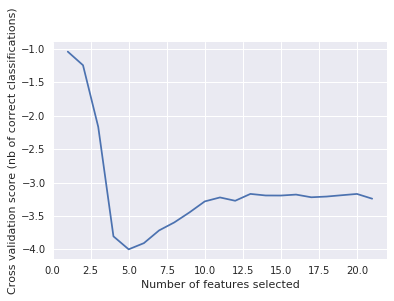

In [45]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(rfecv.step * np.arange(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfecv3 = RFECV(logreg, scoring='neg_log_loss', verbose=1)
rfecv3.fit(X, y)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.


RFECV(cv=None,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_log_loss', step=1, verbose=1)

In [38]:
display(rfecv3.n_features_, min(rfecv3.grid_scores_), max(rfecv3.grid_scores_))

16

-1.0447266749069339

-0.91187141444366515

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [67]:
nn.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
import keras, keras.utils

In [56]:
outenc = sklearn.preprocessing.LabelEncoder()
y = outenc.fit_transform(y)
outbin = sklearn.preprocessing.LabelBinarizer()
y = outbin.fit_transform(y)

In [39]:
test = pd.read_csv('test.csv')
X_te = purify_1(test)
X_te.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
0,True,2015-10-12 12:00:00,Dog,1,300.0,Labrador Retriever,Red/White,1,True,0
1,True,2014-07-26 17:00:00,Dog,1,730.0,German Shepherd/Siberian Husky,Black/Tan,1,True,1
2,True,2016-01-13 12:00:00,Cat,0,365.0,Domestic Shorthair,Brown Tabby,1,False,1
3,True,2013-12-28 18:00:00,Dog,0,120.0,Collie Smooth,Tricolor,1,False,0
4,True,2015-09-24 17:00:00,Dog,0,730.0,Miniature Poodle,White,1,False,1


In [40]:
test.isnull().sum()

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

In [41]:
X_te.loc[X_te['AgeuponOutcome'].isnull()]

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
763,False,2016-02-18 19:00:00,Cat,2,NaN,Domestic Shorthair,Black,1,False,0
2498,False,2016-02-16 18:00:00,Cat,0,NaN,Domestic Longhair,Blue/White,1,True,0
6323,False,2016-02-10 18:00:00,Cat,0,NaN,Domestic Shorthair,Black,1,False,0
6347,False,2016-02-12 18:00:00,Cat,0,NaN,Domestic Shorthair,Brown Tabby,1,False,0
7626,False,2016-02-19 18:00:00,Cat,1,NaN,Domestic Shorthair,Tortie,1,False,0
10754,False,2016-02-12 18:00:00,Cat,0,NaN,Domestic Shorthair,White/Black,1,True,1


In [42]:
for T in applied_transforms[1:]:
    print(T, type(X_te))
    X_te = T(X_te)

<function <lambda> at 0x7f2786e3df28> <class 'pandas.core.frame.DataFrame'>


TypeError: invalid type comparison

In [ ]:
display(X.head(), X_te.head())

In [ ]:
X_te.columns

In [ ]:
clrs_cnts = pd.concat((X.Color, X_te.Color)).value_counts()
clrs_cnts[clrs_cnts < 25].hist(cumulative=True, bins=25)
clrs_cnts